<a href="https://colab.research.google.com/github/prajeeta15/braintumordetection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Packages:

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader ,ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
import random
import cv2
import sys


Reading the dataset:

In [3]:
tumor=[]
healthy=[]
for i in glob.iglob("/content/drive/MyDrive/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("/content/drive/MyDrive/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [4]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [5]:
healthy.shape

(85, 128, 128, 3)

In [6]:
tumor.shape

(86, 128, 128, 3)

In [7]:
np.random.choice(10,5,replace=False)

array([3, 4, 9, 2, 7])

Visualizing the MRI Brain Scans:

In [20]:
import glob
import numpy as np
import cv2
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torch
import matplotlib.pyplot as plt

def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

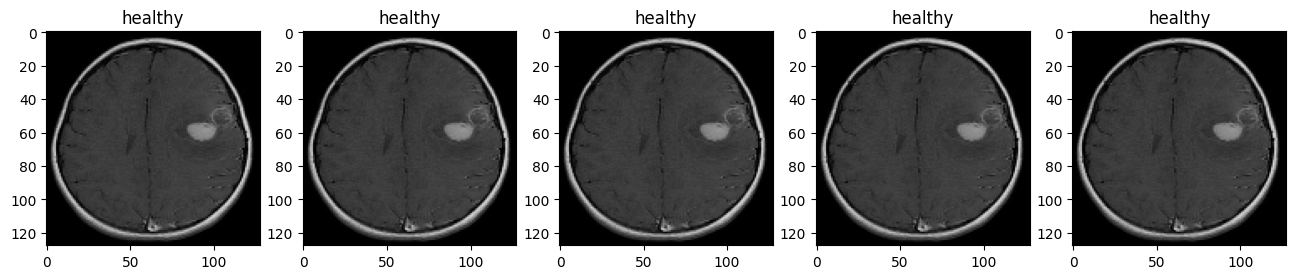

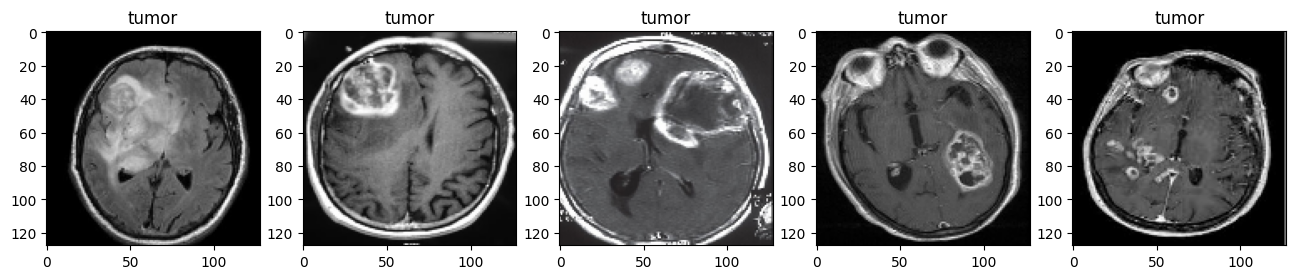

In [43]:
plot_random(healthy,tumor,num=5)

Torch DataSet Class:
An abstract class representing a Dataset.
All other datasets should subclass it. All subclasses should override
``__len__``, that provides the size of the dataset, and ``__getitem__`` supporting integer indexing in range from 0 to len(self) exclusive.

In [35]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

MRI custom DataSet class:

In [47]:
class MRI(Dataset):
    def __init__(self):

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("/content/drive/MyDrive/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("/content/drive/MyDrive/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):

        sample = {'image': self.images[index], 'label':self.labels[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [48]:
mri_dataset = MRI()
mri_dataset.normalize()

Creating Dataloader:
DataLoader is a generic utility to be used as part of your application's data fetching layer to provide a simplified and consistent API over various remote data sources such as databases or web services via batching and caching.

In PyTorch, DataLoader is a built-in class that provides an efficient and flexible way to load data into a model for training or inference. It is particularly useful for handling large datasets that cannot fit into memory, as well as for performing data augmentation and preprocessing.

The DataLoader class works by creating an iterable dataset object and iterating over it in batches, which are then fed into the model for processing. The dataset object can be created from a variety of sources, including NumPy arrays, PyTorch tensors, and custom data sources such as CSV files or image directories.

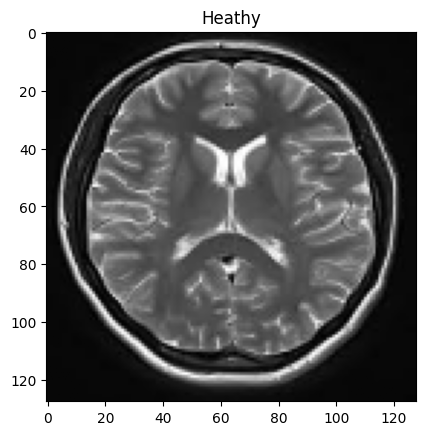

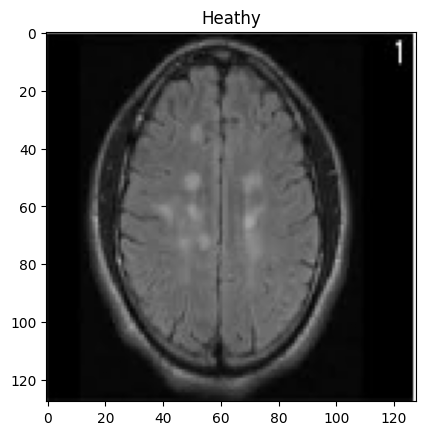

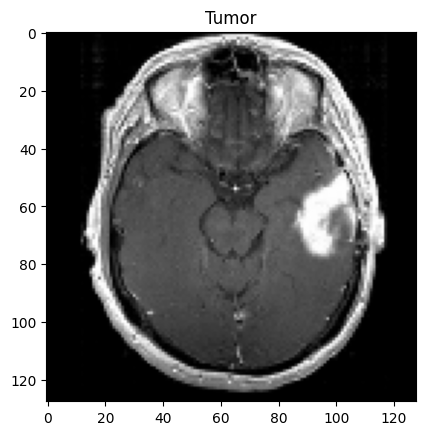

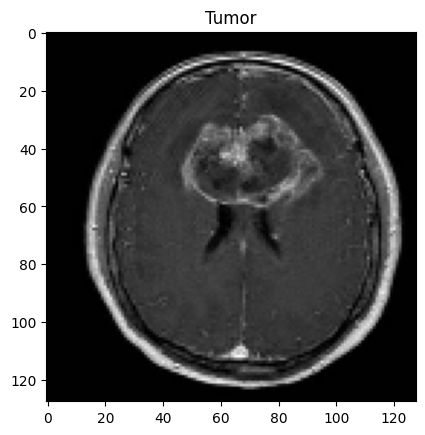

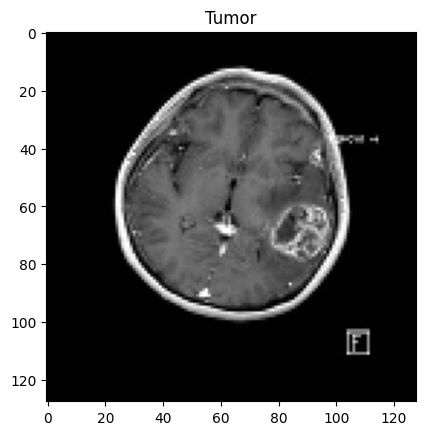

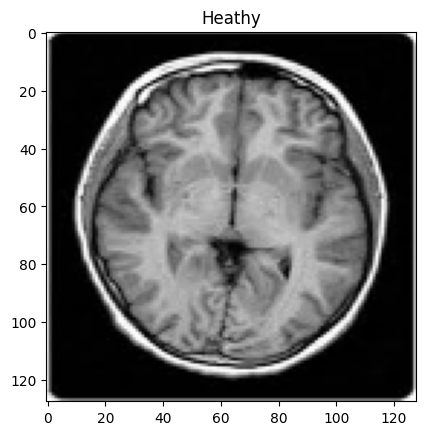

In [50]:
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

Creating the model:
Need to download Nvidia driver on system- http://www.nvidia.com/Download/index.aspx

In [61]:
import torch.nn as nn
import torch.nn.functional as F

device=torch.device('cpu')
model=CNN().to(device)

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

In [69]:
!pip install nvidia-cuda-toolkit

In [69]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [53]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [60]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())


In [60]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [56]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [60]:
accuracy_score(y_true, threshold(outputs))

In [60]:
import seaborn as sns

y_true = np.array([0, 1, 1, 0, 1])
plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

In [60]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

Training the model:

In [ ]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()


In [ ]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Evaluate Model:

In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
accuracy_score(y_true, threshold(outputs))

In [ ]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

Visualizing the feature Maps of the Convolutional Filters:

In [ ]:
model

In [ ]:
no_of_layers = 0
conv_layers = []

In [ ]:
model_children = list(model.children())
model_children

In [ ]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [ ]:
conv_layers

In [ ]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [ ]:
img = torch.from_numpy(img).to(device)

In [ ]:
img.shape

In [ ]:
img = img.unsqueeze(0)
img.shape

In [ ]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()